In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
tfd = tf.contrib.distributions
#import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from visualization import *
from data import *
from autoencoder_keras import *

## Load CIFAR-10 and resize

In [3]:
cifar_data = tf.keras.datasets.cifar10.load_data()
train, test = cifar_data
train_x = train[0]
train_y = train[1]
test_x = test[0]
test_y = test[1]

In [4]:
# open the comments if resize is not going to be used
#train_x_norm = train_x.reshape(-1, 32*32*3)
train_x_norm = train_x / 255

#test_x_norm = test_x_norm.reshape(-1, 32*32*3) 
test_x_norm = test_x / 255

In [5]:
resized_train_x, resized_test_x = resize_images(train_x, test_x) # resize images

In [6]:
limit = 50000

In [7]:
X = resized_train_x[0:limit, :] # get limited number of sample in order to not overwhelm the method
y = train_y[0:limit,0]
images = X.reshape((X.shape[0],20,20,3))

In [8]:
# labels as strings
cifar_labels =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
# separate to train and validation 
X_train, X_val, y_train, y_val, images_train, images_test = train_test_split(X, y, images, train_size=0.8, test_size=0.2)

In [10]:
# get string labels of test dataset for visualization
cif_lab = []
for i in test_y:
    cif_lab.append(cifar_labels[int(test_y[i][0])])

## Define parameters 

In [11]:
activation = tf.keras.layers.LeakyReLU() # define activation
input_dimension = (20*20*3) # define input dimension

In [12]:
# define hidden dimensions
h1 = 600
h2 = 300
h3 = 120
#h4 = 80
h5 = 30

latent_dimension = 2
learn_rate = 8e-4

optimizer = tf.keras.optimizers.Adam(learn_rate)
mse = tf.keras.losses.MeanSquaredError()

## Fully connected network

In [13]:
# create encoder and decoder
num_layers = 4
input_data, encoded = encoder(input_dimension, latent_dimension, activation, h1, h2, h5, h3, num_layers)
decoded = decoder(input_dimension, encoded, activation, h1, h2, h5, h3, num_layers)

In [14]:
# define autoencoder model
autoencoder_model = tf.keras.Model(input_data, decoded)

encoder = tf.keras.Model(input_data, encoded) # encoder, defined to visualize the latent space

autoencoder_model.compile(optimizer=optimizer, loss=mse)  # add optimizer and loss to model

In [15]:
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1200)]            0         
_________________________________________________________________
dense (Dense)                (None, 600)               720600    
_________________________________________________________________
batch_normalization (BatchNo (None, 600)               2400      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 120)               36120     
_________________________________________________________________
batch_normalization_2 (Batch (None, 120)               480   

In [16]:
# train the model
x_train = X

history = autoencoder_model.fit(x_train, x_train,
                epochs=10, # epoch number
                batch_size=256,
                shuffle=True, 
                validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 9s 228us/sample - loss: 0.0365 - val_loss: 0.0456
Epoch 2/10
40000/40000 [==============================] - 7s 164us/sample - loss: 0.0332 - val_loss: 0.0373
Epoch 3/10
40000/40000 [==============================] - 7s 170us/sample - loss: 0.0329 - val_loss: 0.0337
Epoch 4/10
40000/40000 [==============================] - 6s 158us/sample - loss: 0.0327 - val_loss: 0.0332
Epoch 5/10
40000/40000 [==============================] - 6s 160us/sample - loss: 0.0327 - val_loss: 0.0338
Epoch 6/10
40000/40000 [==============================] - 6s 160us/sample - loss: 0.0326 - val_loss: 0.0341
Epoch 7/10
40000/40000 [==============================] - 6s 159us/sample - loss: 0.0325 - val_loss: 0.0340
Epoch 8/10
40000/40000 [==============================] - 7s 182us/sample - loss: 0.0323 - val_loss: 0.0318
Epoch 9/10
40000/40000 [==============================] - 6s 160us/sample - loss: 0.03

## Predicting test data

In [17]:
# predict calculate mean square error
k = autoencoder_model.predict(resized_test_x)
mse(resized_test_x, k).numpy()

0.03447735

In [18]:
gen_data = encoder.predict(resized_test_x) # generate latent space using encoder only

## Plotting loss functions

Text(0.5, 0, 'Epoch')

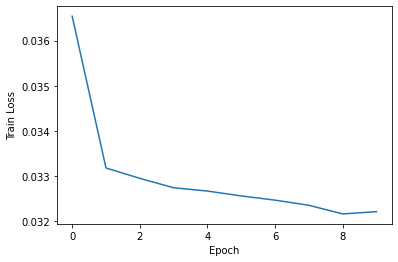

In [19]:
# plot train loss
plt.plot(history.history['loss'])
plt.ylabel('Train Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

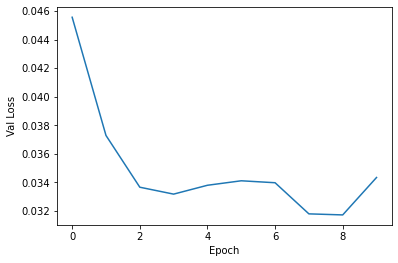

In [20]:
# plot validation loss
plt.plot(history.history['val_loss'])
plt.ylabel('Val Loss')
plt.xlabel('Epoch')

In [22]:
#define filename to use while saving plots
h4 = ""
filename = "cifar_data50k_testing1_" + str(int(learn_rate*10000))+"e-4" + "_"+str(h1) + "_"+str(h2) + "_"+str(h3) + "_"+ str(h4) + "_"+ str(h5)

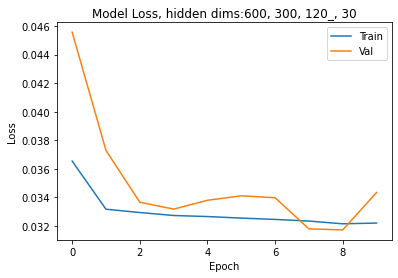

In [23]:
# Plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss, hidden dims:'+str(h1) + ", "+str(h2) + ", "+ str(h3) + "_"+ str(h4)  + ", "+ str(h5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("loss_"+filename+".png")
plt.show()

### Visualization

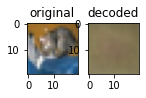

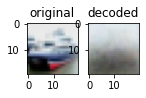

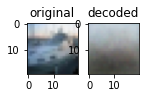

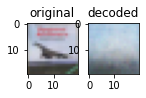

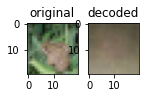

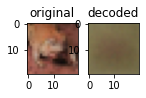

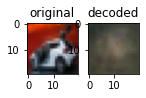

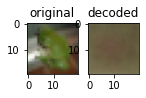

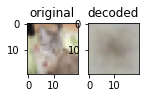

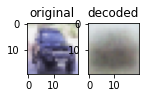

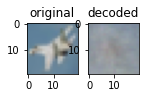

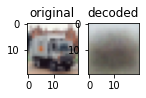

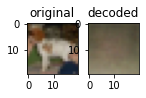

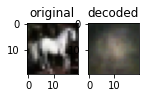

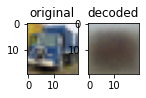

In [24]:
# plot reconstructed images
print_comparison_test(resized_test_x, k, (20,20,3))

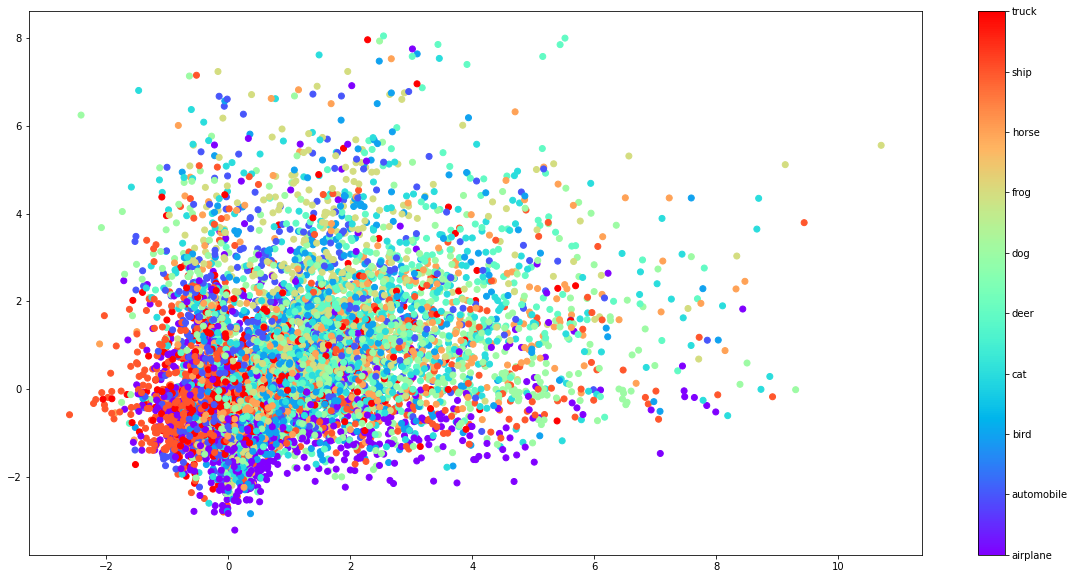

In [25]:
# plot predicted latent space in 2D
plot_embedding(gen_data, cif_lab, test_y, p=1, text_data=False, text_labels=cifar_labels ,figsize=(20,10), name=filename)

## CONVOLUTIONAL NEURAL NETWORK

In [26]:
latent_dimension = 3
learning_rate = 6e-4
input_size = (20,20,3) #define input size

In [27]:
# define encoder and decoder
input_data_cnn, encod, x_shape = encoder_cnn(input_size, activation, latent_dimension)
decod = decoder_cnn(encod, activation, x_shape)

optimizer_cnn = tf.keras.optimizers.Adam(learning_rate) # define optimizer with new learning rate again

# define autoencoder model
autoencoder = tf.keras.Model(input_data_cnn, decod)
cnn_encoder = tf.keras.Model(input_data_cnn, encod) # encoder, defined to visualize the latent space
autoencoder.compile(optimizer=optimizer_cnn, loss=mse) # add optimizer and loss to model

In [28]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 20, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 20, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        3692

In [29]:
x_train = X.reshape((X.shape[0],20,20,3)) # reshape the data points for training

history = autoencoder.fit(x_train, x_train,
                epochs=3, # epoch is chosen 3 for now because this process takes a long time.
                batch_size=256,
                shuffle=True, 
                validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 142s 4ms/sample - loss: 0.0359 - val_loss: 0.0537
Epoch 2/3
40000/40000 [==============================] - 143s 4ms/sample - loss: 0.0308 - val_loss: 0.0413
Epoch 3/3
40000/40000 [==============================] - 150s 4ms/sample - loss: 0.0303 - val_loss: 0.0315


In [30]:
x_test = resized_test_x.reshape((resized_test_x.shape[0],20,20,3)) #reshape the test set

# predict calculate mean square error of test set
cnn_pred = autoencoder.predict(x_test)
mse(x_test, cnn_pred).numpy()

0.03159902

### Plot loss functions

Text(0.5, 0, 'Epoch')

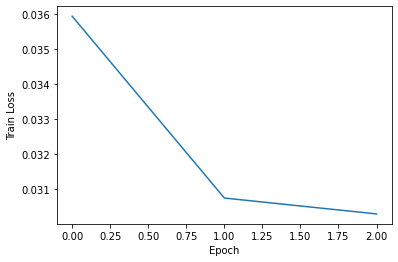

In [31]:
# Plot training loss 
plt.plot(history.history['loss'])
plt.ylabel('Train Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

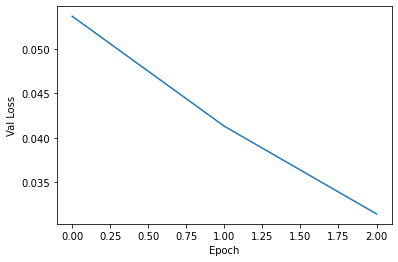

In [32]:
# Plot validation loss
plt.plot(history.history['val_loss'])
plt.ylabel('Val Loss')
plt.xlabel('Epoch')

In [33]:
gen_cnn = cnn_encoder.predict(x_test) # generate latent space

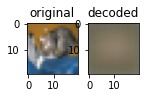

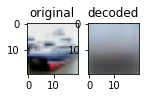

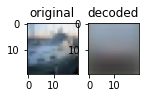

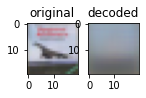

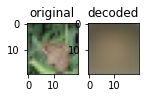

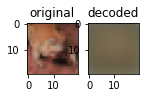

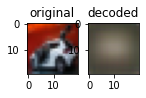

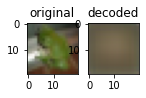

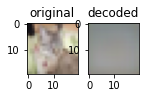

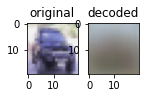

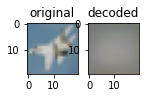

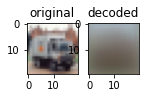

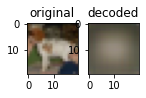

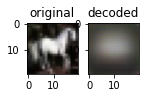

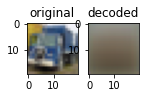

In [34]:
# plot reconstructed images
print_comparison_test(x_test, cnn_pred, (20,20,3))

In [35]:
#define filename to use while saving plots
filename1 = "cifar_resized_cnn_"+str(int(learning_rate*10000))+"e-4" +"_testing1epochs_32-64-128"

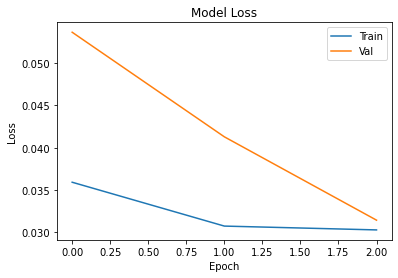

In [36]:
# Plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("loss_"+filename1+".png")
plt.show()

## Plot latent visualization

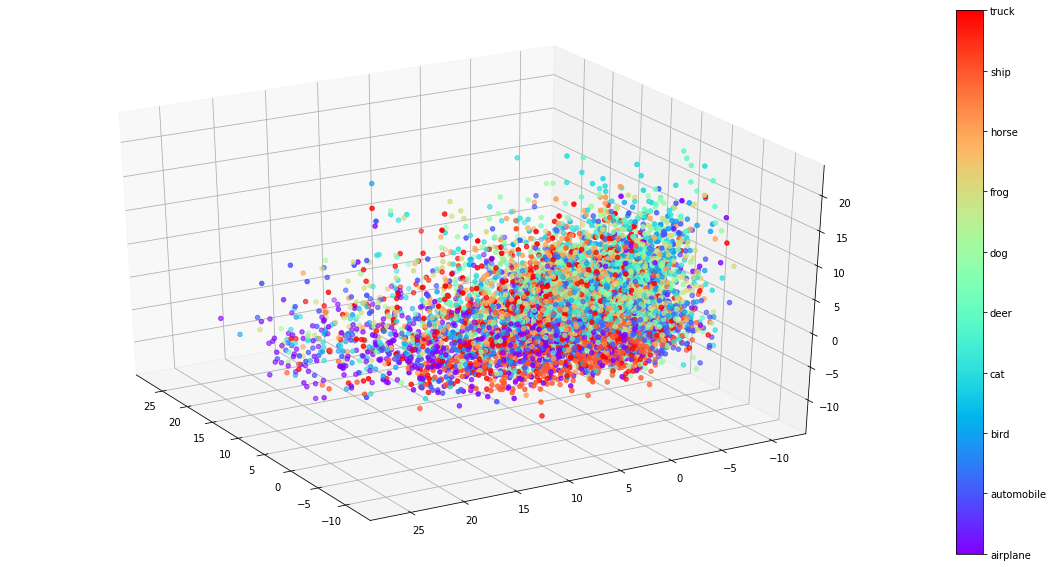

In [37]:
# plot 3D
plot_3D_embedding_cifar(gen_cnn, test_y, cifar_labels, name=filename1)